In [30]:
import numpy as np
import pandas as pd
import scanpy as sc
import scrublet as scr
import os
import warnings
import functools
import seaborn as sns
import scipy.stats
import anndata
import sys
sys.path.append('/Users/kt16/Documents/Clatworthy_scRNAseq/NC_study/scripts')
from tools import cmp, exportDEres
sc.logging.print_versions()

sys.path.append('/Users/kt16/Documents/Github/dandelion')
import dandelion as ddl

warnings.filterwarnings('ignore')
os.chdir(os.path.expanduser('/Users/kt16/Documents/Clatworthy_scRNAseq/NC_study/scanpy'))

scanpy==1.5.1 anndata==0.7.1 umap==0.4.3 numpy==1.17.5 scipy==1.5.2 pandas==1.1.0 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 leidenalg==0.8.0


In [31]:
# read in files
adata = sc.read_h5ad('out/adata_combined.h5ad')
adata

AnnData object with n_obs × n_vars = 67873 × 828 
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label', 'leiden_B'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'age_group_colors', 'broad_label_colors', 'cohort_colors', 'fine_label_colors', 'gender_colors', 'leiden', 'leiden_B_colors', 'leiden_R_colors', 'leiden_colors', 'leiden_label_colors', 'neighbors', 'patient_colors', 'pca', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

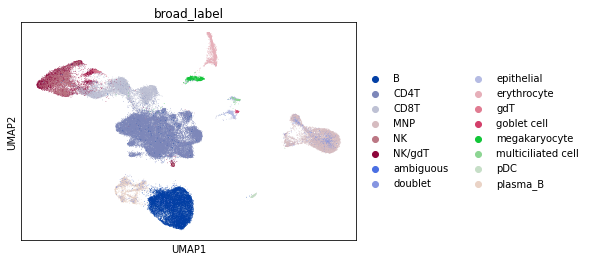

In [32]:
sc.pl.umap(adata, color = 'broad_label')

In [33]:
# subset to CD8 T cells
adata2 = sc.AnnData(X = adata.raw.X, obs = adata.obs, uns = adata.uns, obsm = adata.obsm, var = adata.raw.var, obsp = adata.obsp)
adata2.raw = adata2

In [42]:
adata3 = adata2[~(adata2.obs['broad_label'].isin(['ambiguous', 'doublet']))]
adata3

View of AnnData object with n_obs × n_vars = 66638 × 18504 
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label', 'leiden_B'
    uns: 'age_group_colors', 'cohort_colors', 'gender_colors', 'leiden', 'leiden_B_colors', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'patient_colors', 'pca', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

In [43]:
sc.pp.highly_variable_genes(adata3, min_mean=0.0125, max_mean=3, min_disp=0.5)

Trying to set attribute `.var` of view, copying.


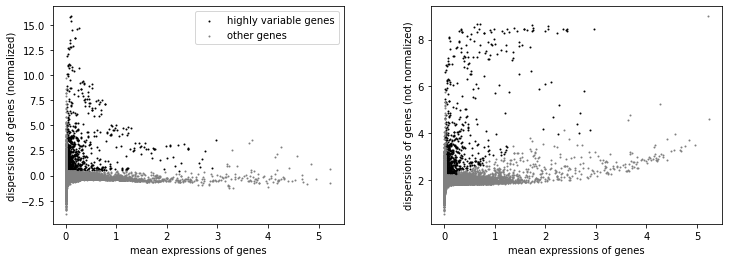

In [44]:
sc.pl.highly_variable_genes(adata3)

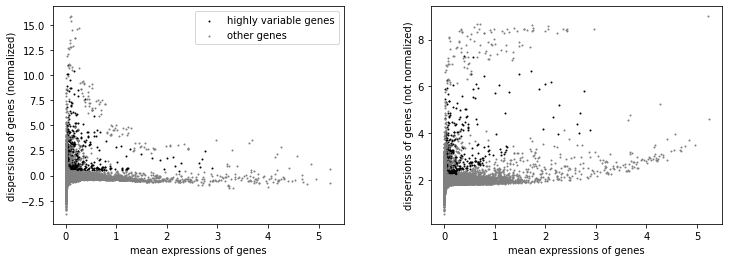

In [45]:
## remove TRBV/TRAV/DJ and IGHV/IGLV/IGKV/DJ from the highly variable genes
import re
for i in adata3.var.index:
    if re.search('^TR[AB][VDJ]|^IG[HKL][VDJ]', i):
        adata3.var.at[i, 'highly_variable'] = False
sc.pl.highly_variable_genes(adata3)

In [46]:
# filter to only highly variable
adata3 = adata3[:, adata3.var['highly_variable']]
adata3

View of AnnData object with n_obs × n_vars = 66638 × 830 
    obs: 'sampleid', 'patient', 'sampletype', 'age_group', 'gender', 'cohort', 'scrublet_score', 'n_genes', 'percent_mito', 'n_counts', 'bh_pval', 'is_doublet', 'filter_rna', 'batch', 'leiden', '__is_in_cluster__', 'fine_label', 'broad_label', 'leiden_R', 'leiden_label', 'leiden_B'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'age_group_colors', 'cohort_colors', 'gender_colors', 'leiden', 'leiden_B_colors', 'leiden_R_colors', 'leiden_label_colors', 'neighbors', 'patient_colors', 'pca', 'sampletype_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    obsp: 'connectivities', 'distances'

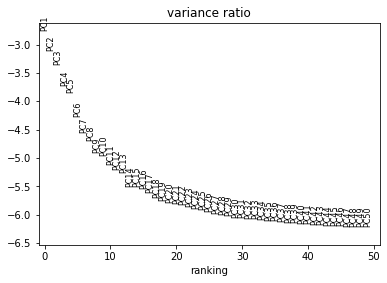

In [47]:
# regress and scale for PCA
sc.pp.regress_out(adata3, ['n_counts', 'percent_mito'])
sc.pp.scale(adata3, max_value = 10)
# Principal component analysis
sc.tl.pca(adata3, svd_solver = 'arpack')
sc.pl.pca_variance_ratio(adata3, log = True, n_pcs = 50)

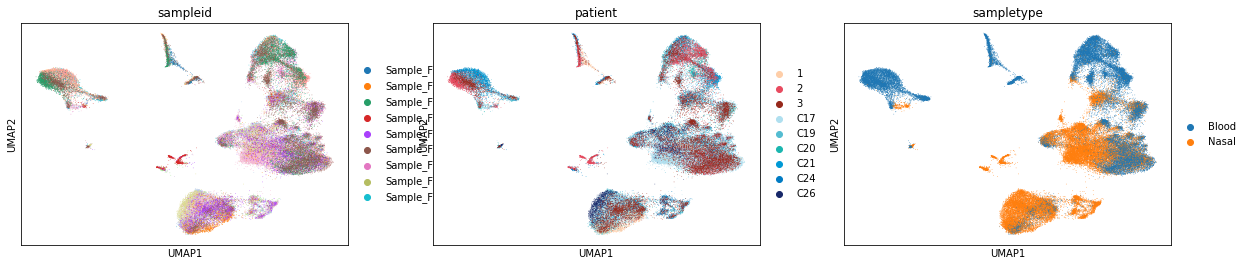

In [48]:
# run BBKNN
sc.external.pp.bbknn(adata3, batch_key = 'patient', neighbors_within_batch=10)
# UMAP
sc.tl.umap(adata3, n_components = 2, min_dist = 0.3)
sc.pl.umap(adata3, color=['sampleid', 'patient', 'sampletype'])

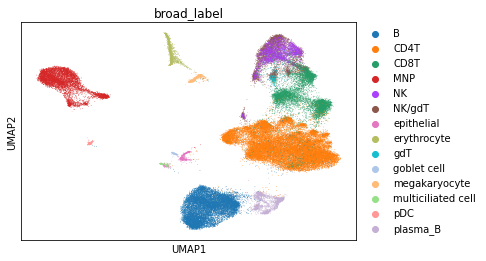

In [49]:
sc.pl.umap(adata3, color=['broad_label'])

In [50]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

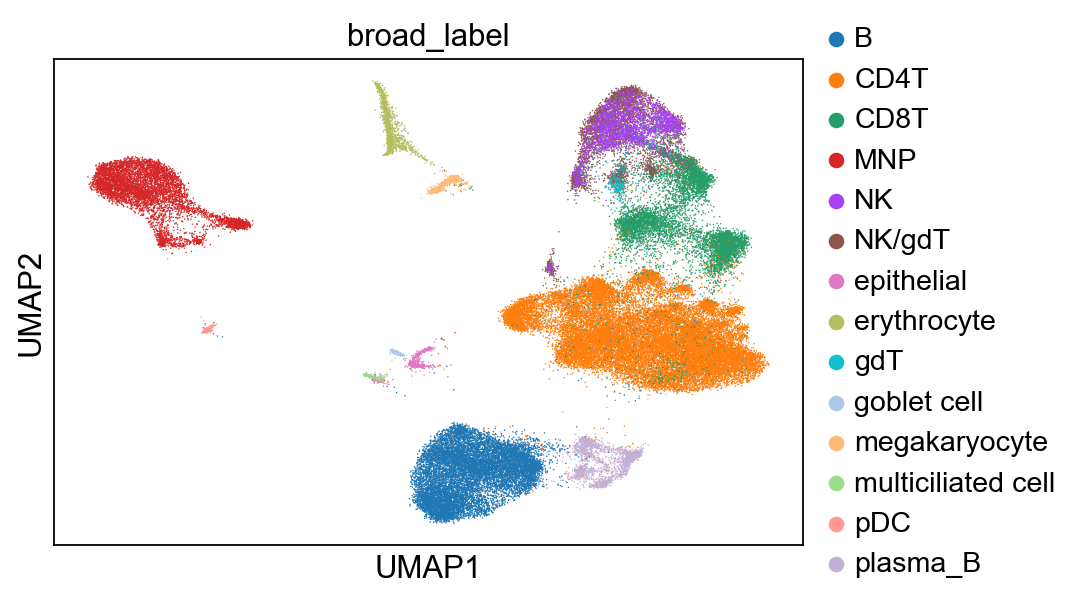

In [64]:
sc.settings.set_figure_params(vector_friendly=True, dpi_save=900, figsize=(6,4))
sc.pl.umap(adata3, color=['broad_label'], save = '/broad_label_umap.pdf')

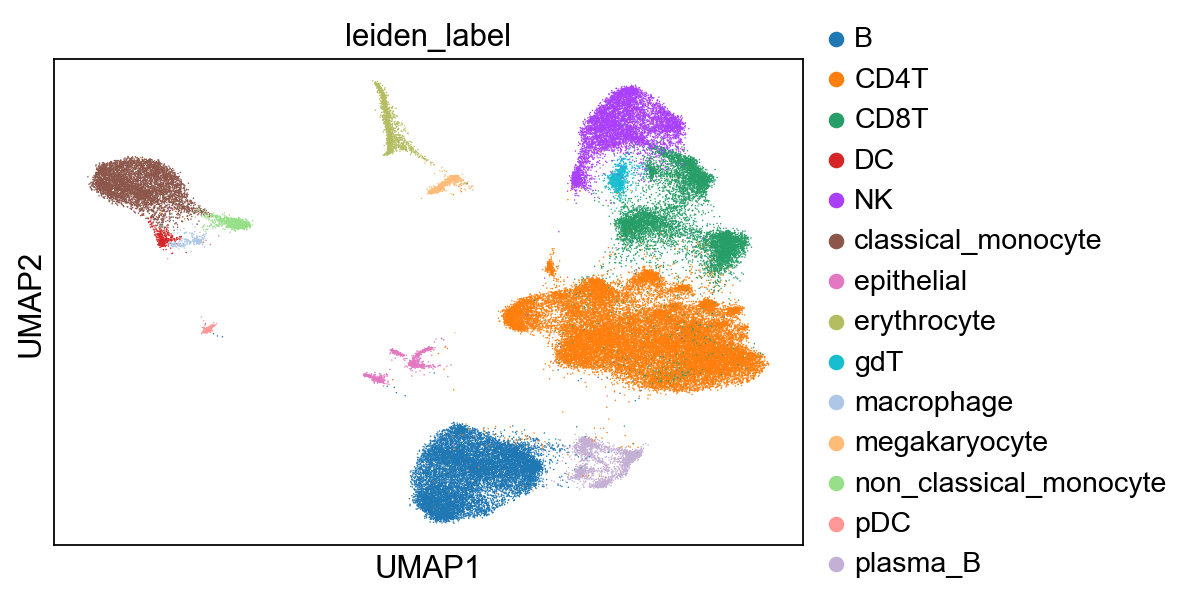

In [65]:
sc.settings.set_figure_params(vector_friendly=True, dpi_save=900, figsize=(6,4))
sc.pl.umap(adata3, color=['leiden_label'], save = '/leiden_label_umap.pdf')

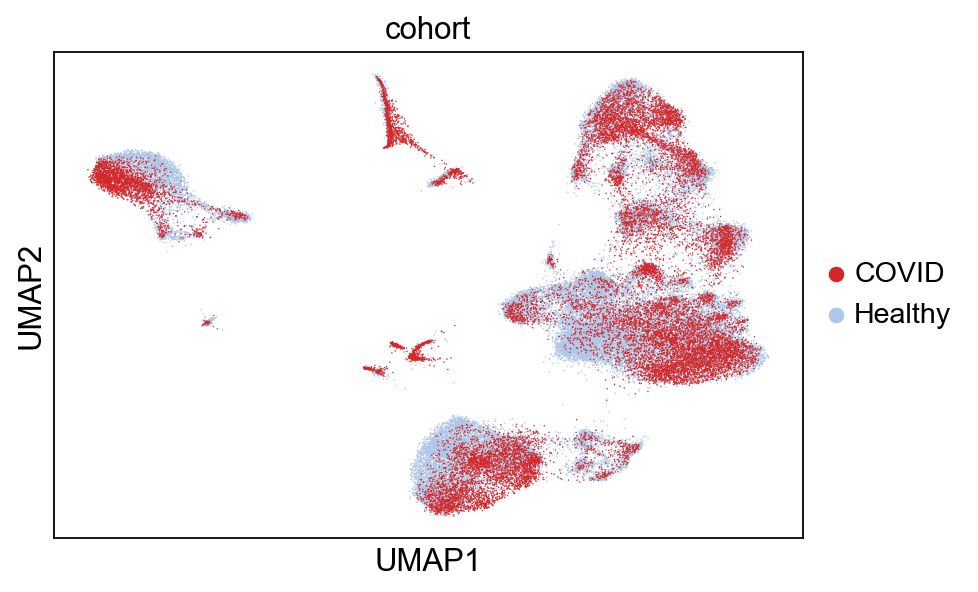

In [66]:
sc.settings.set_figure_params(vector_friendly=True, dpi_save=900, figsize=(6,4))
sc.pl.umap(adata3, color=['cohort'], save = '/cohort_umap.pdf')

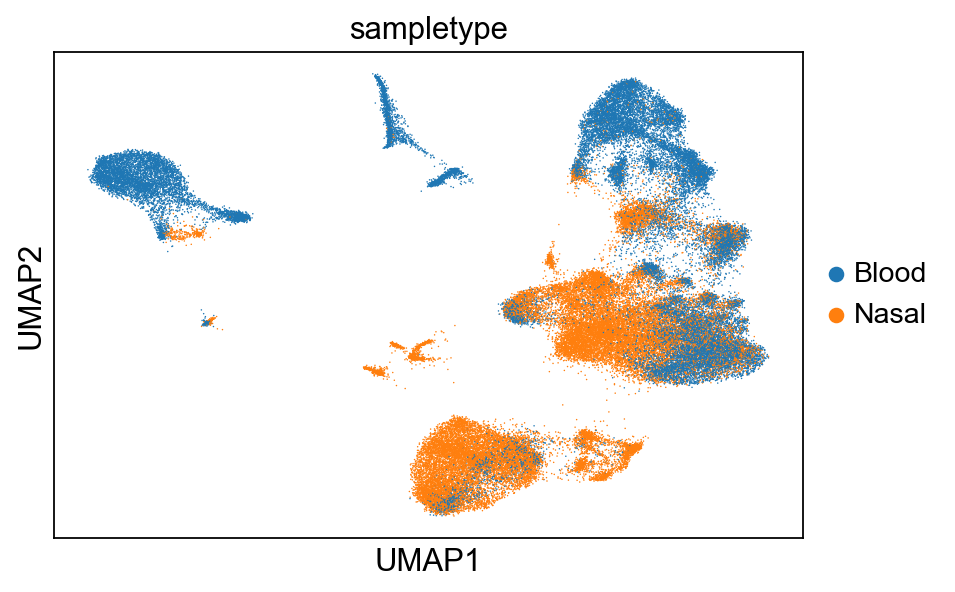

In [67]:
sc.pl.umap(adata3, color=['sampletype'], save = '/sampletype_umap.pdf')

In [70]:
# generate files for cellphoneDB?
adata3.raw.X

<66638x18504 sparse matrix of type '<class 'numpy.float32'>'
	with 53548257 stored elements in Compressed Sparse Row format>